In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,"../python/rrvf2017/")

In [3]:
from rrvf_data import read_data,show_data,show_data2,show_features, normalize, DataGen

In [4]:
columns,data=read_data("../input/train_test_ext.npy.npz")
len(columns),data.shape

(1, 829, 517) (59, 829, 517)


(67, (829, 517, 67))

In [5]:
gc.collect()

15

In [6]:
#show_data(data,columns, 1,480, None)

In [7]:
#show_data2(data,columns)

# cv

In [8]:
n_reg_lookback=28

In [9]:
def get_index(cols):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [10]:
rawy=data[:,:,get_index(['visitors'])[0]].copy()
rawy.shape

(829, 517)

In [11]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [12]:
def make_ondate_train_test(ondate_cols):
    ondate_train_test=data[:,:,get_index(ondate_cols)].copy()
    ondate_train_test=normalize(ondate_train_test)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'weekday6', 'holiday', 'TMAX']+
                  ['store_nan_week_ratio', 'store_y1_week_ratio', 'store_y2_week_ratio', 'store_y4_week_ratio', 'store_y4_week_ratio'])

In [14]:
def make_lag_train_test(lag_cols):
    lag_train_test=data[:,:,get_index(lag_cols)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [16]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [17]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [18]:
import cPickle as pickle
indexes=[pickle.load(open(u)) for  u in ['train_idx_1.pkl','train_idx_2.pkl','train_idx_3.pkl']]

In [19]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [20]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    return  df2['error2'].mean()
def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=478-39)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [23]:
reload(rrvf)
import rrvf_data
def _run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols)
    lag_train_test = make_lag_train_test(lag_cols)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testconv", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=True,use_dropout=False,model_type="conv",
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [24]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [1]:
reload(rrvf)
j=0
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    _,validpred,pred478=run_once(indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('conv_valid{}_preds_tmp2.pkl'.format(j),'wb'))

NameError: name 'rrvf' is not defined

In [27]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

In [28]:
test_truth=rawy[:,478-39:478]
test_truth.shape

(829, 39)

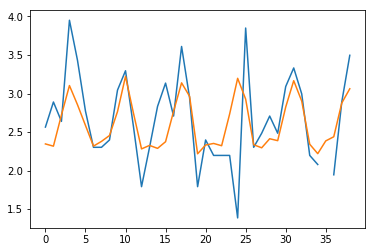

In [29]:
plt.plot(test_truth[129])
plt.plot(testpreds[129])

In [30]:
MSE(test_truth.reshape(-1),testpreds.reshape(-1))

0.280229282252979

In [31]:
np.sqrt(0.27809914084615828)

0.52735106034420587

In [32]:
lst=[]
for i in range(39):
    lst.append(MSE(test_truth[:,i],testpreds[:,i]))
    d=rrvf_data.idx_to_date([i+478-39])[0]
    print i, d, pd.to_datetime(d).weekday()+1, lst[-1]
np.mean(lst[:8]),np.mean(lst[:]),np.mean(lst[-8:])

0 2017-03-15 3 0.243185212761
1 2017-03-16 4 0.25076468293
2 2017-03-17 5 0.200861337259
3 2017-03-18 6 0.207271654397
4 2017-03-19 7 0.379941403767
5 2017-03-20 1 0.355754167312
6 2017-03-21 2 0.366173386565
7 2017-03-22 3 0.272837536038
8 2017-03-23 4 0.261583337904
9 2017-03-24 5 0.24876791222
10 2017-03-25 6 0.2376420211
11 2017-03-26 7 0.308200843532
12 2017-03-27 1 0.30917991746
13 2017-03-28 2 0.310275510762
14 2017-03-29 3 0.29521493117
15 2017-03-30 4 0.297012432993
16 2017-03-31 5 0.255695121943
17 2017-04-01 6 0.252561194106
18 2017-04-02 7 0.340655107017
19 2017-04-03 1 0.332605386259
20 2017-04-04 2 0.32167098895
21 2017-04-05 3 0.28814545827
22 2017-04-06 4 0.315139269698
23 2017-04-07 5 0.261335361474
24 2017-04-08 6 0.229643091383
25 2017-04-09 7 0.355415229938
26 2017-04-10 1 0.316506607271
27 2017-04-11 2 0.314392685465
28 2017-04-12 3 0.28180293552
29 2017-04-13 4 0.279201351883
30 2017-04-14 5 0.230685406244
31 2017-04-15 6 0.208042790963
32 2017-04-16 7 0.296222711

(0.28459867262864197, 0.28335532250754458, 0.26634201177518108)

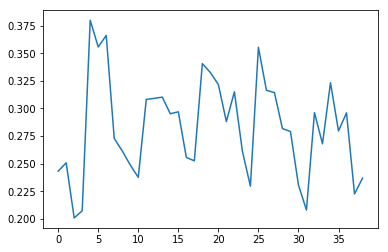

In [33]:
plt.plot(lst)

In [34]:
lst=[]
for i in range(test_truth.shape[0]):
    lst.append(MSE(test_truth[i],testpreds[i]))

/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [35]:
lst=np.array(lst)
lst[np.isnan(lst)]=5

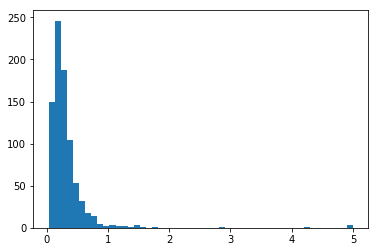

In [36]:
plt.hist(lst,bins=50);